In [11]:
# data:
image_dir = "../data/raw/all_images"
label_file = "../data/raw/dental_images.csv"
image_size = (512, 512)
batch_size = 32
validation_split = 0.2
test_split = 0.15
image_type = "photo"
# model:
model_name = "VGG16"
weights = "IMAGENET1K_V1"
num_classes = 4

# training:
epochs = 30
learning_rate = 0.0001
save_path = "../outputs/models/"

# evaluation:
metrics = ["accuracy", "precision", "recall", "f1_score"]

# data loading and preprocessing


In [12]:

import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            labels_df (pd.DataFrame): DataFrame with filtered image labels.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.image_dir = image_dir
        self.labels = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx]['file_name'])
        try:
            image = Image.open(img_name).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image {img_name} not found.")

        label = self.labels.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

def load_labels(label_file, image_type):
    labels = pd.read_csv(label_file)
    if 'image_type' not in labels.columns or 'category' not in labels.columns:
        raise KeyError("Label file must contain 'image_type' and 'category' columns.")
    labels = labels[labels['image_type'] == image_type]
    labels['label'] = labels['category'].astype('category').cat.codes
    return labels

def create_transforms(image_size):
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5456, 0.3630, 0.3329], std=[0.1742, 0.1712, 0.1552])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5456, 0.3630, 0.3329], std=[0.1742, 0.1712, 0.1552])
    ])

    test_transform = val_transform  # Use the same transform for validation and test

    return train_transform, val_transform, test_transform

def create_datasets(image_dir, labels, train_transform, val_transform, test_transform, test_split, validation_split):
    indices = list(range(len(labels)))
    train_idx, test_idx = train_test_split(
        indices, test_size=test_split, stratify=labels['label'], random_state=42)

    train_idx, val_idx = train_test_split(
        train_idx, test_size=validation_split / (1 - test_split), stratify=labels.iloc[train_idx]['label'], random_state=42)

    train_dataset = ImageDataset(image_dir, labels.iloc[train_idx], transform=train_transform)
    val_dataset = ImageDataset(image_dir, labels.iloc[val_idx], transform=val_transform)
    test_dataset = ImageDataset(image_dir, labels.iloc[test_idx], transform=test_transform)

    return train_dataset, val_dataset, test_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

#def load_data(image_dir, label_file, image_type, image_size, test_split, validation_split, batch_size):
def load_data():
    labels = load_labels(label_file, image_type)
    train_transform, val_transform, test_transform = create_transforms(image_size)
    train_dataset, val_dataset, test_dataset = create_datasets(
        image_dir, labels, train_transform, val_transform, test_transform, test_split, validation_split)
    return create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size)


# Model creation

In [13]:
import torch.nn as nn
import torchvision.models as models

def get_model(model_name, num_classes, weights=None):
    """
    Initialize and return a model with the specified architecture and weights.

    Args:
        model_name (str): Name of the model architecture to use.
        num_classes (int): Number of output classes.
        weights (str, optional): Pre-trained weights to load.

    Returns:
        nn.Module: The initialized model with the custom classifier.
    """
    if model_name == "VGG16":
        model = models.vgg16(weights=weights)
        for param in model.features.parameters():
            #param.requires_grad = False
            #model.classifier[1] = nn.Linear(model.classifier[6].in_features, num_classes)
            #model.classifier[4] = nn.Linear(model.classifier[6].in_features, num_classes)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    # elif model_name == "ResNet18":
    #     model = models.resnet18(weights=weights)
    #     model.fc = nn.Linear(model.fc.in_features, num_classes)
    # elif model_name == "DenseNet121":
    #     model = models.densenet121(weights=weights)
    #     model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    # # Add other models as needed
    # else:
    #     raise ValueError(f"Model {model_name} not supported")
    # Wrap the model with DataParallel
    
    return model


# training 

In [14]:
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
# from src.model import get_model
# from src.data_loading import load_data
# from src.utils import save_model
# from src.metrics import calculate_metrics

def train_model():
    
    
     # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    accuracies = []
    
    #load data
    train_loader, val_loader, _ = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = get_model(model_name, num_classes, weights)
    # Move model to GPU and wrap with DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        
     # Calculate class weights based on training labels
    train_labels = [label for _, label in train_loader.dataset]
    class_weights = get_class_weights(train_labels)
    
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            #labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # Free GPU memory
            torch.cuda.empty_cache()
            
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
        # # Validation
        # val_metrics = calculate_metrics(model, val_loader, device, criterion)
        # print(f"Validation Metrics: {val_metrics}")
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        # Validation
        model.eval()
        val_metrics = calculate_metrics(model, val_loader, device, criterion)
        print(f"Validation Metrics: {val_metrics}")
        epoch_val_loss = val_metrics.get('loss', float('inf'))  # Set default value if loss is not returned
        val_losses.append(epoch_val_loss)
        accuracies.append(val_metrics['accuracy'])
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader),
        }
        torch.save(checkpoint, save_path + f"_epoch{epoch+1}.pth")
    
    save_model(model, save_path, model_name, image_size, batch_size, epochs, learning_rate)

    # Plotting
    plt.figure(figsize=(12, 5))
    
    epochs_range = range(1, len(train_losses) + 1)  # Ensure x-axis matches length of metrics lists
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(save_path + "_training_metrics.png")
    plt.show()

# evaluation

In [15]:
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
# from src.data_loading import load_data
# from src.utils import load_model
# from src.metrics import calculate_metrics

def evaluate_model():
    _, _, test_loader = load_data()
    model = load_model(
        model_name= model_name, 
        image_size=image_size,  # Replace with actual image size
        batch_size=batch_size, 
        epochs=epochs, 
        learning_rate=learning_rate
    )
   
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    test_metrics = calculate_metrics(model, test_loader, device)
    print(f"Test Metrics: {test_metrics}")
    
    # Confusion Matrix
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
           
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(save_path + "_confusion_matrix.png")
    plt.show()

# metrics

In [16]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(model, dataloader, device, criterion=None):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    if criterion:
        metrics['loss'] = total_loss / len(dataloader)
    
    return metrics


# utils


In [17]:
import torch
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# from src.model import get_model

def save_model(model, path, model_name, image_size, batch_size, epochs, learning_rate):
    # Construct the filename with hyperparameters
    filename = f"{model_name}_img{image_size[0]}x{image_size[1]}_batch{batch_size}_epochs{epochs}_lr{learning_rate:.5f}.pth"
    
    # Combine the base path and the filename
    save_path = os.path.join(path, filename)
    
    # Save the model state dictionary
    torch.save(model.state_dict(), save_path)
    
    print(f"Model saved to: {save_path}")

# def load_model (path):
#     model = get_model("VGG16", 4, True)  # Update this if you have different model or parameters
#     model.load_state_dict(torch.load(path))
#     return model

def load_model(model_name, image_size, batch_size, epochs, learning_rate):
    # Construct the filename from parameters
    filename = f"{model_name}_img{image_size[0]}x{image_size[1]}_batch{batch_size}_epochs{epochs}_lr{learning_rate:.5f}.pth"
    model_path = os.path.join(save_path, filename)
    
    # Ensure that the model file exists
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The model file at {model_path} does not exist.")
    
    model = get_model(model_name, num_classes, weights=None)  # Adjust parameters as needed
     # Load the state dictionary
    state_dict = torch.load(model_path)
    
    # If model was saved using DataParallel, adjust the keys
    if list(state_dict.keys())[0].startswith('module.'):
        # Remove 'module.' from the start of each key
        state_dict = {k[len('module.'):]: v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)    
    return model


# def get_class_weights(labels):
#     class_weights = compute_class_weight(
#         class_weight='balanced', 
#         classes=np.unique(labels), 
#         y=labels
#     )
#     return torch.tensor(class_weights, dtype=torch.float)

def get_class_weights(labels):
    # Convert labels list to a numpy array
    labels = np.array(labels)
    
    # Get the unique classes from the labels
    classes = np.unique(labels)
    print("Classes:", classes)
    print("Labels:", labels)
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=labels
    )
    
    return torch.tensor(class_weights, dtype=torch.float)

# main scipt


Classes: [0 1 2 3]
Labels: [2 2 0 ... 0 2 3]


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/30, Loss: 0.992265189687411
Validation Metrics: {'accuracy': 0.571830985915493, 'precision': 0.5763781223083548, 'recall': 0.5375900409817878, 'f1_score': 0.4649319451645275, 'loss': 0.7672444432973862}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 2/30, Loss: 0.7522411925925149
Validation Metrics: {'accuracy': 0.6112676056338028, 'precision': 0.6463069212328706, 'recall': 0.6305913621770037, 'f1_score': 0.5794710494278358, 'loss': 0.7043823550144831}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 3/30, Loss: 0.6690659349163374
Validation Metrics: {'accuracy': 0.6676056338028169, 'precision': 0.6659362510289291, 'recall': 0.6685263435122112, 'f1_score': 0.6343358232770857, 'loss': 0.5954114695390066}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 4/30, Loss: 0.6117120923267471
Validation Metrics: {'accuracy': 0.6901408450704225, 'precision': 0.6655875998041897, 'recall': 0.6332120903912877, 'f1_score': 0.6131848903079127, 'loss': 0.6571871985991796}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 5/30, Loss: 0.5599312409758568
Validation Metrics: {'accuracy': 0.5746478873239437, 'precision': 0.6958637291169176, 'recall': 0.6683930781302176, 'f1_score': 0.5520154743907536, 'loss': 0.740770955880483}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 6/30, Loss: 0.5480242040422227
Validation Metrics: {'accuracy': 0.7436619718309859, 'precision': 0.6900565250023454, 'recall': 0.6788720805114248, 'f1_score': 0.667622062565338, 'loss': 0.6580498094360033}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 7/30, Loss: 0.4945964457260238
Validation Metrics: {'accuracy': 0.5577464788732395, 'precision': 0.6836986490212296, 'recall': 0.649188767221554, 'f1_score': 0.53573672473194, 'loss': 1.0707439184188843}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 8/30, Loss: 0.44643084622091717
Validation Metrics: {'accuracy': 0.6676056338028169, 'precision': 0.7288809703601967, 'recall': 0.7349716954295812, 'f1_score': 0.6449074486639254, 'loss': 0.5451789622505506}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 9/30, Loss: 0.40933795852793586
Validation Metrics: {'accuracy': 0.7718309859154929, 'precision': 0.7099488604686673, 'recall': 0.7127688861436742, 'f1_score': 0.7043844536737938, 'loss': 0.6044701611002287}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 10/30, Loss: 0.35028616049223477
Validation Metrics: {'accuracy': 0.7070422535211267, 'precision': 0.696385302664005, 'recall': 0.6844241560465416, 'f1_score': 0.6595825228759233, 'loss': 0.9569156244397163}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 11/30, Loss: 0.340848956671026
Validation Metrics: {'accuracy': 0.7830985915492957, 'precision': 0.7600935520452765, 'recall': 0.7719214914664322, 'f1_score': 0.745997666758895, 'loss': 0.5688630510121584}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 12/30, Loss: 0.3969229662583934
Validation Metrics: {'accuracy': 0.7098591549295775, 'precision': 0.6581101755450859, 'recall': 0.6698408272602733, 'f1_score': 0.6509338359849869, 'loss': 0.6421096076567968}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 13/30, Loss: 0.4610036921997865
Validation Metrics: {'accuracy': 0.6507042253521127, 'precision': 0.6973248106060607, 'recall': 0.6903110956389644, 'f1_score': 0.6267507233318874, 'loss': 0.8378039573629698}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 14/30, Loss: 0.34326787665486336
Validation Metrics: {'accuracy': 0.7098591549295775, 'precision': 0.7597150661350622, 'recall': 0.7726186292890647, 'f1_score': 0.6848524139645146, 'loss': 0.5295816858609518}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 15/30, Loss: 0.3404710454245408
Validation Metrics: {'accuracy': 0.7098591549295775, 'precision': 0.7467847752007826, 'recall': 0.755541162579037, 'f1_score': 0.685188526857911, 'loss': 0.534618309388558}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 16/30, Loss: 0.2952159473465549
Validation Metrics: {'accuracy': 0.7408450704225352, 'precision': 0.73411483230659, 'recall': 0.7495437838710874, 'f1_score': 0.7077486402486403, 'loss': 0.5041614202782512}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 17/30, Loss: 0.3158046060966121
Validation Metrics: {'accuracy': 0.7323943661971831, 'precision': 0.7377212452946414, 'recall': 0.7617281357106116, 'f1_score': 0.7062706010239147, 'loss': 0.5599175579845905}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 18/30, Loss: 0.24270163869692218
Validation Metrics: {'accuracy': 0.8056338028169014, 'precision': 0.746682297111731, 'recall': 0.7564669450197997, 'f1_score': 0.7492216117216117, 'loss': 0.556242955227693}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 19/30, Loss: 0.2636362528945837
Validation Metrics: {'accuracy': 0.7605633802816901, 'precision': 0.7438838223632037, 'recall': 0.7648913105950981, 'f1_score': 0.7249859379750684, 'loss': 0.5516896198193232}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 20/30, Loss: 0.20681513659656048
Validation Metrics: {'accuracy': 0.7549295774647887, 'precision': 0.7065811016757169, 'recall': 0.692943264268872, 'f1_score': 0.6850066551888055, 'loss': 0.9408077026406924}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 21/30, Loss: 0.15474070929404762
Validation Metrics: {'accuracy': 0.8253521126760563, 'precision': 0.7829536534893679, 'recall': 0.8131851972298553, 'f1_score': 0.7877898208863179, 'loss': 0.5899536985283097}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 22/30, Loss: 0.20568534757735002
Validation Metrics: {'accuracy': 0.7915492957746478, 'precision': 0.737243891678345, 'recall': 0.7496780496073883, 'f1_score': 0.7398783600099865, 'loss': 0.6396375919381777}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 23/30, Loss: 0.1476062253738443
Validation Metrics: {'accuracy': 0.7971830985915493, 'precision': 0.7333146489869868, 'recall': 0.7405381942549834, 'f1_score': 0.7354209855090137, 'loss': 0.900322196384271}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 24/30, Loss: 0.20503058108604616
Validation Metrics: {'accuracy': 0.7577464788732394, 'precision': 0.7092808766037113, 'recall': 0.6750480715715312, 'f1_score': 0.6644643401035573, 'loss': 1.0350328832864761}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 25/30, Loss: 0.17682516026414102
Validation Metrics: {'accuracy': 0.8366197183098592, 'precision': 0.7792245285195454, 'recall': 0.767848812634002, 'f1_score': 0.7692787878969318, 'loss': 0.7144418129076561}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 26/30, Loss: 0.15261091421254808
Validation Metrics: {'accuracy': 0.8, 'precision': 0.7636135888072642, 'recall': 0.749796436992593, 'f1_score': 0.7439206550081131, 'loss': 0.8934619501233101}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 27/30, Loss: 0.13592685665935278
Validation Metrics: {'accuracy': 0.8225352112676056, 'precision': 0.7763401713730953, 'recall': 0.7098401943088205, 'f1_score': 0.7109880938690665, 'loss': 0.8530707410536706}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 28/30, Loss: 0.12412341019242173
Validation Metrics: {'accuracy': 0.7943661971830986, 'precision': 0.7749566170843274, 'recall': 0.7539050376387856, 'f1_score': 0.7479517973149283, 'loss': 0.839038801980981}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 29/30, Loss: 0.13193331017262405
Validation Metrics: {'accuracy': 0.8338028169014085, 'precision': 0.7792037358966493, 'recall': 0.7744614092409458, 'f1_score': 0.776650392188328, 'loss': 0.6584232607856393}


/home/boukhari/projects/dental_image_project/.venv/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 30/30, Loss: 0.11150901825425939
Validation Metrics: {'accuracy': 0.7464788732394366, 'precision': 0.7425702339302512, 'recall': 0.7474844363058043, 'f1_score': 0.7123480663134205, 'loss': 0.6837057801506793}
Model saved to: ../outputs/models/VGG16_img512x512_batch32_epochs30_lr0.00010.pth


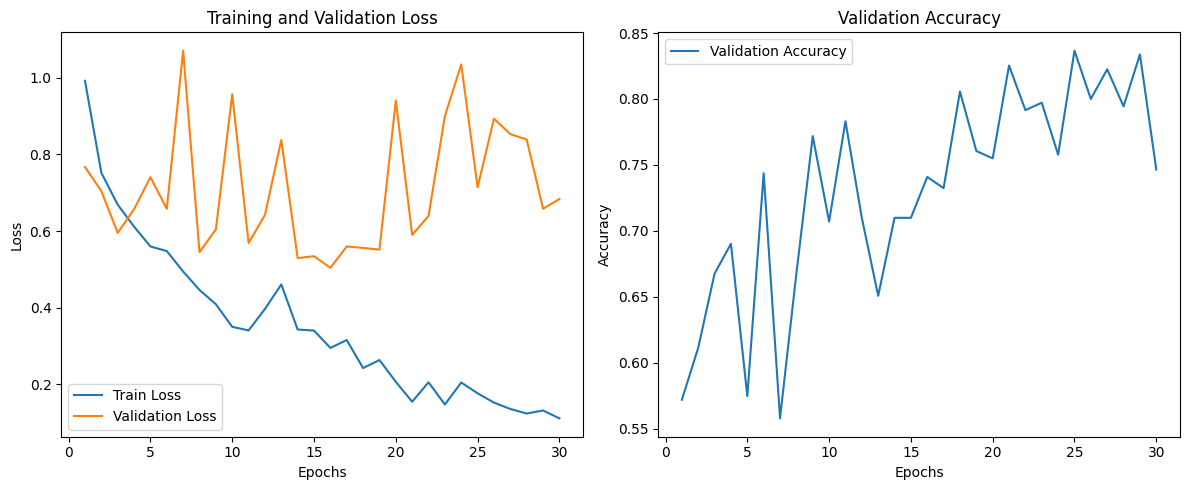

/tmp/ipykernel_232221/1200939961.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Test Metrics: {'accuracy': 0.7518796992481203, 'precision': 0.7419176822066513, 'recall': 0.7416666666666666, 'f1_score': 0.7129392446633827}


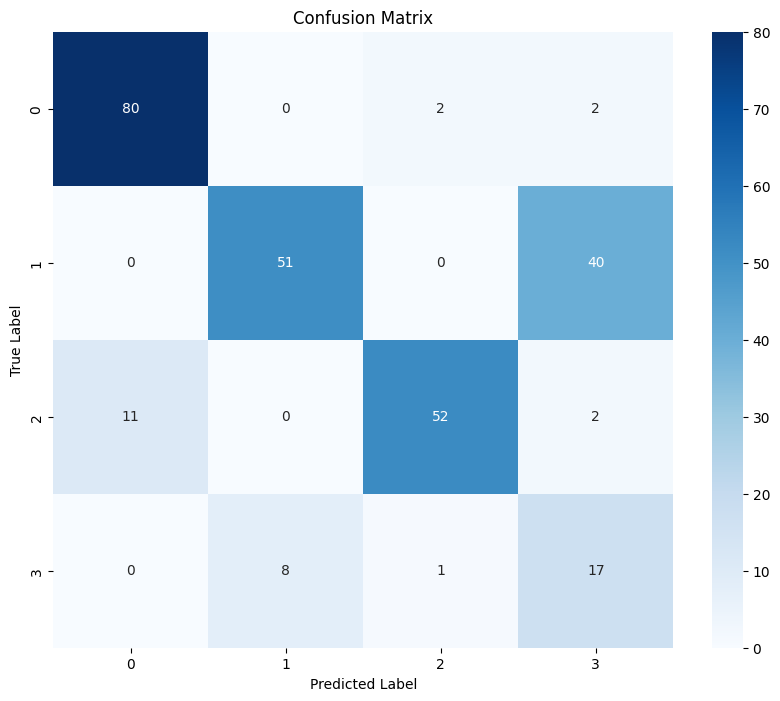

In [18]:
import yaml
# from src.train import train_model
# from src.evaluate import evaluate_model

if __name__ == "__main__":
    #with open('/home/boukhari/projects/dental_image_project/configs/config.yaml', "r") as file:
        #config = yaml.safe_load(file)
    
    train_model()
    evaluate_model()
